# Анализ данных

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set_theme()

## Data loading

In [2]:
oil = pd.read_csv("./data/raw/oil.csv", parse_dates=["date"], index_col="date")
train_raw = pd.read_csv("./data/raw/train.csv", parse_dates=["date"], index_col="id")
test_raw = pd.read_csv("./data/raw/test.csv", parse_dates=["date"], index_col="id")
stores = pd.read_csv("./data/raw/stores.csv", index_col="store_nbr")
holidays = pd.read_csv("./data/raw/holidays_events.csv", parse_dates=["date"], index_col="date")
transactions = pd.read_csv("./data/raw/transactions.csv", parse_dates=["date"], index_col="date")
sample_submission = pd.read_csv("./data/raw/sample_submission.csv")

In [3]:
def preprocess_data(data):
    data = data.copy()
    processed = data.merge(holidays['type'], on='date', how='left')
    processed = processed.merge(stores['cluster'], on='store_nbr', how='left')
    processed = processed.merge(oil, on='date', how='left')
    processed['is_holiday'] = processed['type'].notna().astype(int)
    processed['oil_price'] = processed['dcoilwtico']
    processed.drop(["onpromotion", "dcoilwtico", "type"], axis=1, inplace=True)
    processed.dropna(inplace=True)
    return processed

In [4]:
train_preprocess = preprocess_data(train_raw)
test = preprocess_data(test_raw)

In [5]:
categories = pd.unique(train_preprocess["family"])
store_nbrs = pd.unique(train_preprocess["store_nbr"])
clusters = pd.unique(train_preprocess["cluster"])
print(*categories)
print(*store_nbrs)
print(*clusters)
train = train_preprocess.loc[(train_preprocess["family"]==categories[0]) & (train_preprocess["store_nbr"] == store_nbrs[0])]
# train.set_index("date", inplace=True)


AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY CELEBRATION CLEANING DAIRY DELI EGGS FROZEN FOODS GROCERY I GROCERY II HARDWARE HOME AND KITCHEN I HOME AND KITCHEN II HOME APPLIANCES HOME CARE LADIESWEAR LAWN AND GARDEN LINGERIE LIQUOR,WINE,BEER MAGAZINES MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD
1 10 11 12 13 14 15 16 17 18 19 2 20 21 22 23 24 25 26 27 28 29 3 30 31 32 33 34 35 36 37 38 39 4 40 41 42 43 44 45 46 47 48 49 5 50 51 52 53 54 6 7 8 9
13 15 6 7 3 12 16 9 1 10 8 2 4 5 11 14 17


In [6]:
def plot_train(data):
    plt.figure(figsize=(12,6))
    plt.plot(data.index, data['sales']/np.max(data['sales']), label='Sales')
    plt.plot(data.index, data['oil_price']/np.max(data['oil_price']), label='Oil Price', alpha=0.7)
    plt.legend()
    plt.show()

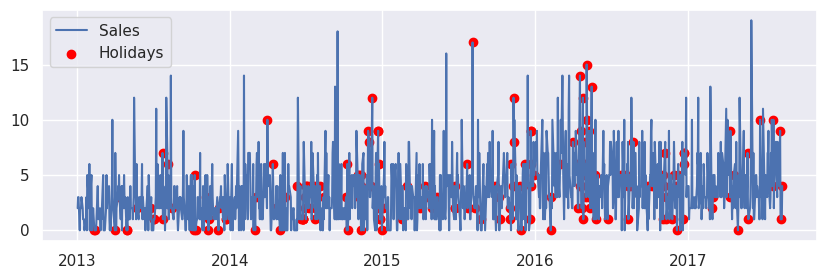

In [7]:
plt.figure(figsize=(10, 3))
plt.plot(train["date"], train['sales'], label='Sales')
plt.scatter(train.loc[train['is_holiday'] == 1, 'date'], train.loc[train['is_holiday'] == 1, 'sales'], color='red', label='Holidays')
plt.legend()

In [8]:
def interpolate_holidays(data):
    data = data.copy()
    threshold = data['sales'].quantile(0.95)
    data.loc[data['sales'] > threshold, 'sales'] = np.nan
    data['sales'] = data['sales'].interpolate()
    return data

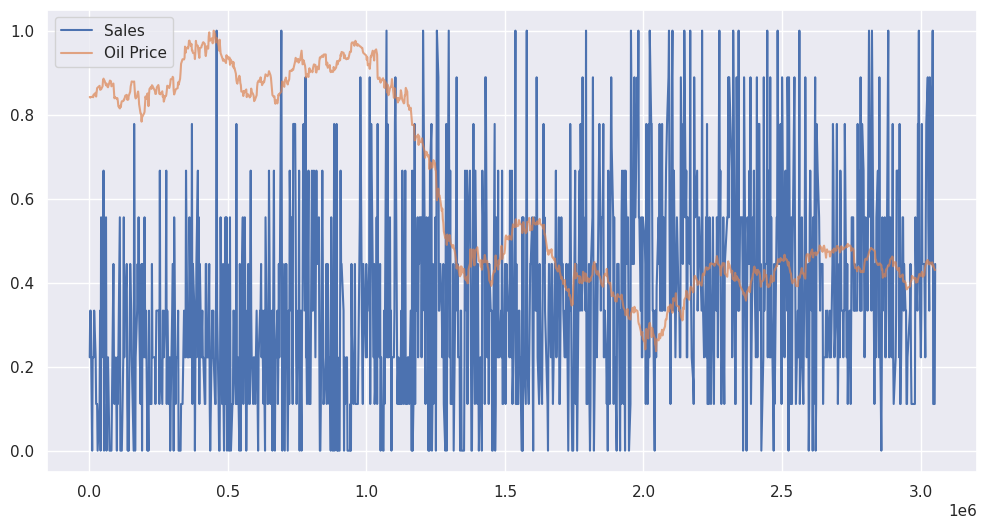

In [9]:
# Try wider windows for bigger spikes
smoothed_train = interpolate_holidays(train)
plot_train(smoothed_train)

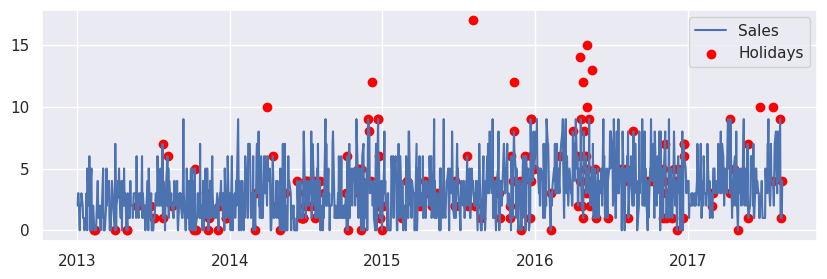

In [10]:
plt.figure(figsize=(10, 3))
plt.plot(smoothed_train['date'], smoothed_train['sales'], label='Sales')
plt.scatter(train.loc[train['is_holiday'] == 1, 'date'], train.loc[train['is_holiday'] == 1, 'sales'], color='red', label='Holidays')
plt.legend()

In [11]:
train = smoothed_train

In [12]:
def process_data(data, train=True):
    data = preprocess_data(data)
    if train:
        data = interpolate_holidays(data)
    return data

In [13]:
process_data(train_raw).to_csv("./data/processed/train.csv")
process_data(test_raw, train=False).to_csv("./data/processed/test.csv")

## Анализ сезонности и авторегрессии, и тренда

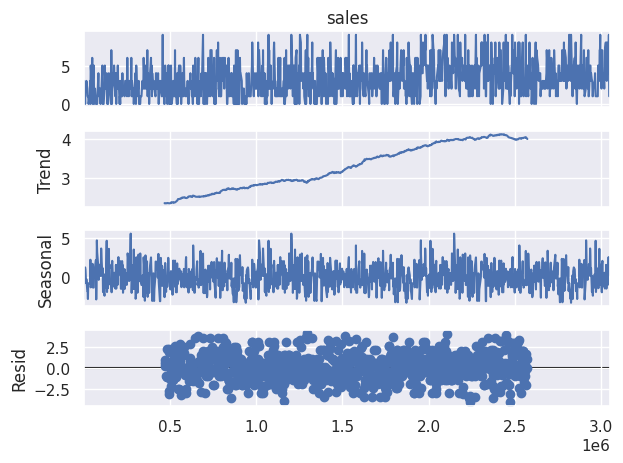

In [14]:
decomposition = seasonal_decompose(train["sales"], model='additive', period=365)
decomposition.plot()
plt.show()

In [15]:
# Merge trend and oil prices
analysis_df = pd.DataFrame({
    'date': train['date'],
    'trend': decomposition.trend,
    'oil_price': train['oil_price']  # Assuming oil prices are in your DataFrame
}).dropna()  # Remove rows with missing values

correlation = analysis_df["oil_price"].corr(decomposition.trend, method="pearson") # Так как тренд близок к линейному важнее Пирсон
print(f"Корреляция Пирсона между трендом и oil_prices: {correlation:.2f}")
correlation = analysis_df['trend'].corr(analysis_df['oil_price'], method='spearman')
print(f"Корреляция Спирмена между трендом и oil_prices: {correlation:.2f}")

Корреляция Пирсона между трендом и oil_prices: -0.87
Корреляция Спирмена между трендом и oil_prices: -0.83


Имеем сильную обратную корреляцию

/tmp/ipykernel_241209/517154335.py:1: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  analysis_df_normalized = (analysis_df - analysis_df.mean()) / analysis_df.std()


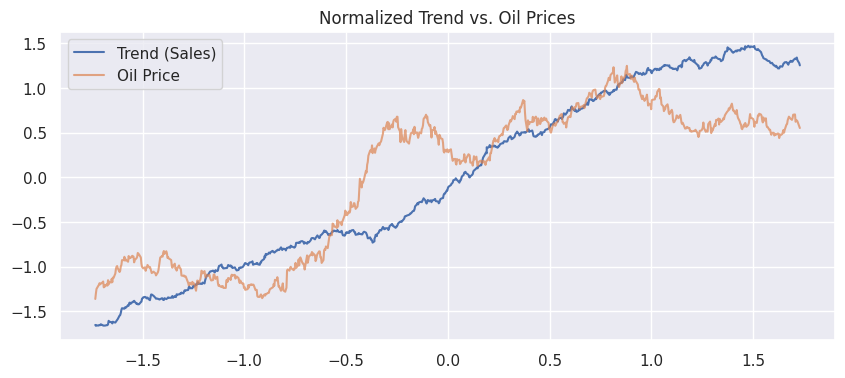

In [16]:
analysis_df_normalized = (analysis_df - analysis_df.mean()) / analysis_df.std()
plt.figure(figsize=(10, 4))
plt.plot(analysis_df_normalized['date'], analysis_df_normalized['trend'], label='Trend (Sales)')
plt.plot(analysis_df_normalized['date'], -0.82*analysis_df_normalized['oil_price'], label='Oil Price', alpha=0.7)
plt.legend()
plt.title("Normalized Trend vs. Oil Prices")
plt.show()

### Определяем сезонность

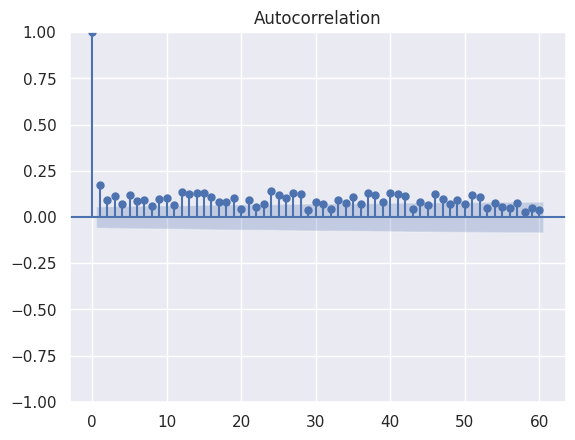

In [17]:
plot_acf(train["sales"], lags=60)
plt.show()

Мы наблюдаем пики на 4, 8, 12 дне, что говорит о 4-дневной сезонности.

In [18]:
season = 4

### Определяем стационарности (необходимость дифференциирования)

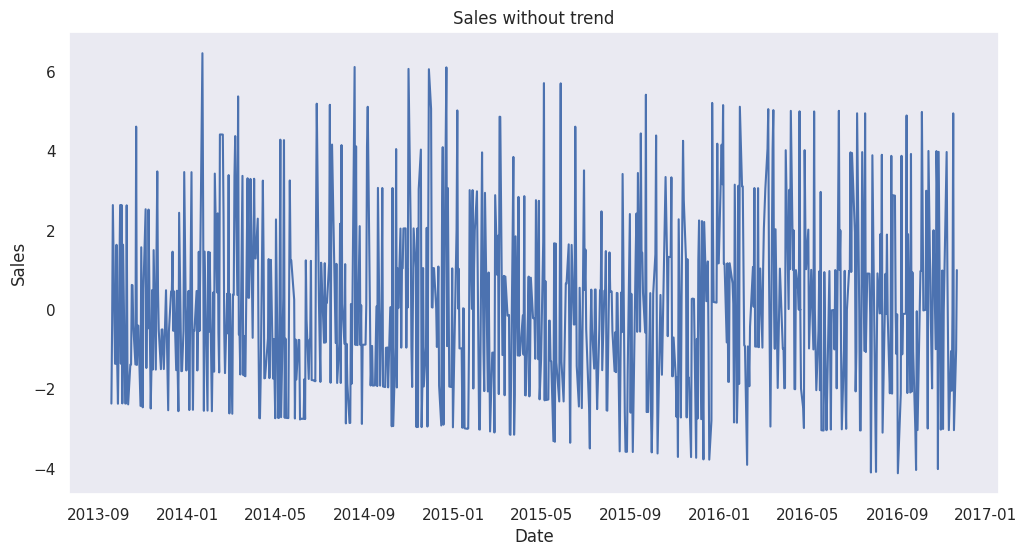

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(train['date'], train['sales']-decomposition.trend)
plt.title('Sales without trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid()
plt.show()

In [20]:
from statsmodels.tsa.stattools import adfuller, kpss
def is_stationary(data):
    # ADF-тест
    adf_result = adfuller(data.dropna())
    print(f"ADF p-value: {adf_result[1]:.5f}")

    # KPSS-тест
    kpss_result = kpss(data.dropna())
    print(f"KPSS p-value: {kpss_result[1]:.5f}")

is_stationary(train["sales"]-decomposition.trend)
d = D = 0

ADF p-value: 0.00000
KPSS p-value: 0.10000


/tmp/ipykernel_241209/2855336843.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(data.dropna())


Так как p-value в обоих случаях меньше чем 0.05, то ряд стационарен.

### Несезонная автокорреляция

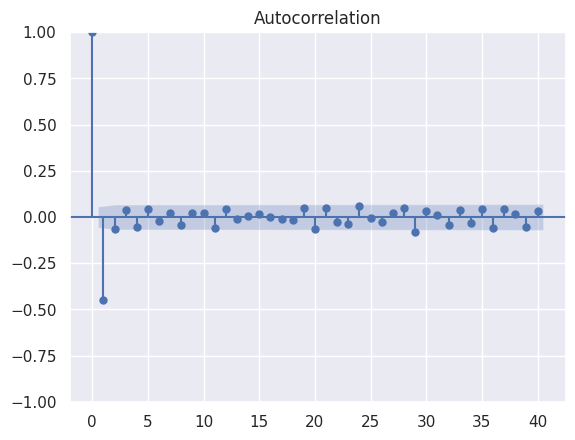

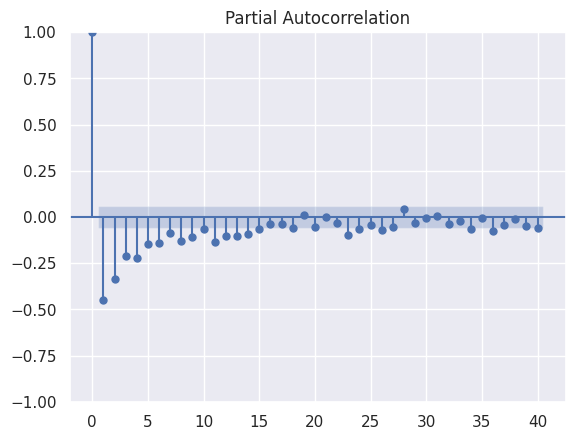

In [21]:
plot_acf(train["sales"].diff().dropna(), lags=40)  # ACF для MA(q)
plot_pacf(train["sales"].diff().dropna(), lags=40)  # PACF для AR(p)
plt.show()

Мы наблюдаем сезонные лаги на 7, 14, 21 днях, но остальная автокорреляция обрывается через 1 день
Частичная автокорреляция обрывается на 6 дне.

In [22]:
q = 3
p = 8

### Сезонная автокорреляция

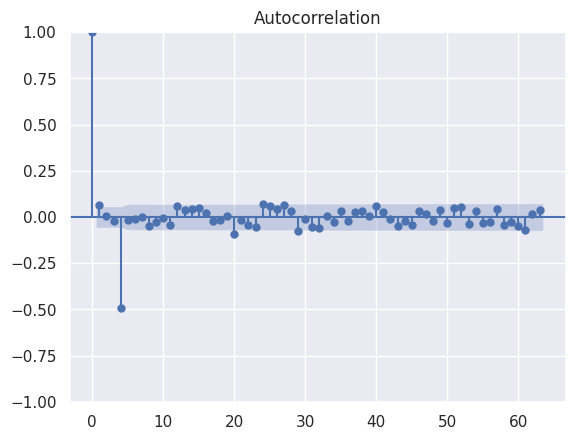

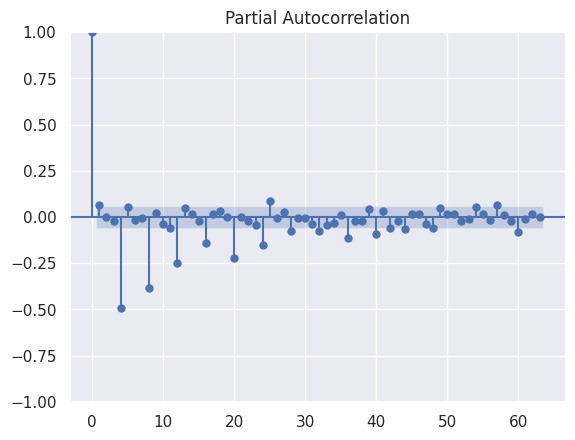

In [23]:
plot_acf(train["sales"].diff(season).dropna(), lags=63)  # ACF для сезонного MA(Q)
plot_pacf(train["sales"].diff(season).dropna(), lags=63)  # PACF для сезонного AR(P)
plt.show()

Мы наблюдаем сезонные лаги на 7 дне, значит сезонная автокорреляция равна 1.
Частичная автокорреляция значима и после шестой недели, но выберем значение 6.

In [24]:
Q = 1
P = 6

In [25]:
order=(p, d, q)
seasonal_order=(P, D, Q, season)
print(f"{order=}\n{seasonal_order=}")

order=(8, 0, 3)
seasonal_order=(6, 0, 1, 4)


# TSFel

,date,store_nbr,family,sales,cluster,is_holiday,oil_price
1782,2013-01-02,1,AUTOMOTIVE,2.0,13,0,93.14
3564,2013-01-03,1,AUTOMOTIVE,3.0,13,0,92.97
5346,2013-01-04,1,AUTOMOTIVE,3.0,13,0,93.12
10692,2013-01-07,1,AUTOMOTIVE,0.0,13,0,93.20
12474,2013-01-08,1,AUTOMOTIVE,2.0,13,0,93.21
...,...,...,...,...,...,...,...
3041874,2017-08-09,1,AUTOMOTIVE,7.0,13,0,49.59
3043656,2017-08-10,1,AUTOMOTIVE,9.0,13,1,48.54
3045438,2017-08-11,1,AUTOMOTIVE,1.0,13,1,48.81
3050784,2017-08-14,1,AUTOMOTIVE,1.0,13,0,47.59


,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Average power,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,...,0_Peak to peak distance,0_Positive turning points,0_Root mean square,0_Signal distance,0_Skewness,0_Slope,0_Standard deviation,0_Sum absolute diff,0_Variance,0_Zero crossing rate
0,50.0,20.5,1.0,4.545455,4.240000,2.0,9.0,1.0,2.0,0.083333,...,3.0,1.0,2.041241,16.055200,-0.358584,-0.104895,0.897527,9.0,0.805556,2.0
1,46.0,18.5,1.0,4.181818,3.608696,2.0,9.0,0.0,2.0,0.083333,...,3.0,1.0,1.957890,16.055200,-0.221987,-0.167832,1.027402,9.0,1.055556,3.0
2,38.0,16.0,1.0,3.454545,3.684211,2.0,9.0,0.0,2.0,0.083333,...,3.0,1.0,1.779513,16.469413,0.000000,-0.132867,0.957427,10.0,0.916667,4.0
3,38.0,16.5,1.0,3.454545,5.526316,2.0,9.0,0.0,2.0,0.083333,...,3.0,1.0,1.779513,15.543204,0.000000,-0.006993,0.957427,9.0,0.916667,3.0
4,38.0,17.0,1.0,3.454545,4.526316,2.0,9.0,0.0,2.0,0.083333,...,3.0,2.0,1.779513,16.469413,0.000000,-0.132867,0.957427,10.0,0.916667,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,470.0,61.5,1.0,42.727273,5.091489,2.0,9.0,3.0,7.0,0.083333,...,8.0,2.0,6.258328,33.703310,0.034972,-0.041958,2.266912,31.0,5.138889,0.0
1163,451.0,63.5,1.0,41.000000,6.461197,2.0,9.0,3.0,7.0,0.083333,...,7.0,2.0,6.130525,27.877120,-0.191811,0.269231,2.126225,25.0,4.520833,0.0
1164,448.0,65.0,1.0,40.727273,5.531250,2.0,9.0,3.0,7.0,0.083333,...,8.0,3.0,6.110101,32.777100,-0.425181,-0.083916,2.285218,30.0,5.222222,0.0
1165,424.0,60.0,1.0,38.545455,4.872642,2.0,9.0,1.0,7.0,0.083333,...,8.0,3.0,5.944185,31.541032,-0.364613,-0.293706,2.624669,28.0,6.888889,0.0


,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Average power,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,...,0_Peak to peak distance,0_Positive turning points,0_Root mean square,0_Signal distance,0_Skewness,0_Slope,0_Standard deviation,0_Sum absolute diff,0_Variance,0_Zero crossing rate
count,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,...,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000
mean,250.120823,39.211654,1.059126,22.738257,5.510123,2.071979,8.196230,1.203942,4.320480,0.083333,...,8.525278,2.679520,4.377983,34.559787,0.803234,0.002783,2.484707,30.898029,6.787674,1.664953
std,143.698715,12.892191,0.253484,13.063520,1.378615,0.614263,2.205183,1.146051,1.683881,0.000000,...,3.030577,0.862871,1.295418,9.595213,0.622236,0.226465,0.783856,10.395476,4.429349,1.769766
min,23.000000,9.500000,1.000000,2.090909,0.801136,0.000000,0.000000,0.000000,0.000000,0.083333,...,3.000000,0.000000,1.384437,14.404918,-0.647171,-0.678322,0.897527,6.000000,0.805556,0.000000
25%,142.000000,29.000000,1.000000,12.909091,4.575200,2.000000,9.000000,0.000000,3.000000,0.083333,...,6.000000,2.000000,3.439961,27.992441,0.359900,-0.139860,1.934698,24.000000,3.743056,0.000000
50%,222.000000,38.500000,1.000000,20.181818,5.525701,2.000000,9.000000,1.000000,4.000000,0.083333,...,8.000000,3.000000,4.301163,33.289097,0.724202,0.003497,2.397916,30.000000,5.750000,2.000000
75%,333.500000,48.000000,1.000000,30.318182,6.438974,2.000000,9.000000,2.000000,5.000000,0.083333,...,10.000000,3.000000,5.271779,40.551165,1.148716,0.153846,2.922017,38.000000,8.538194,3.000000
max,755.000000,80.000000,3.000000,68.636364,10.189655,8.000000,9.000000,8.000000,9.000000,0.083333,...,18.000000,5.000000,7.932003,77.333046,2.689931,0.772727,5.320297,75.000000,28.305556,8.000000


,0_Area under the curve,0_Average power,0_Mean,0_Peak to peak distance,0_Root mean square,0_Signal distance,0_Skewness,0_Slope,0_Standard deviation,0_Sum absolute diff,0_Variance
0,20.5,4.545455,1.833333,3.0,2.041241,16.055200,-0.358584,-0.104895,0.897527,9.0,0.805556
1,18.5,4.181818,1.666667,3.0,1.957890,16.055200,-0.221987,-0.167832,1.027402,9.0,1.055556
2,16.0,3.454545,1.500000,3.0,1.779513,16.469413,0.000000,-0.132867,0.957427,10.0,0.916667
3,16.5,3.454545,1.500000,3.0,1.779513,15.543204,0.000000,-0.006993,0.957427,9.0,0.916667
4,17.0,3.454545,1.500000,3.0,1.779513,16.469413,0.000000,-0.132867,0.957427,10.0,0.916667


0.5224631068071593